Используем библиотеку CVXPY для обучения SVM-классификатора с $\ell_2$-регуляризатором.
Имеем выборку $(x_i,y_i)$, $i=1,\ldots, \ell$. Объекты выборки $x_i \in {\bf R}^7$ (колоски), $y_i \in \{\pm 1\}$ их бинарные метки.
Мы стремимся построить хороший линейный $\hat y = {\rm sign}(w^T x - w_0)$.
Ищем оптимальные параметры $w,w_0$ минимизируя квадратичный функционал

$$
Q(w, w_0) = (1/\ell) \sum\limits_{i=1}^\ell (1 - M_i(w, w_0))_+ + \lambda \|w\|^2 = (1/\ell) \sum_i \left(1 - y_i ( w^T x_i-w_0) \right)_+ + \lambda \| w \|^2 
$$

Первым слагаемым стоит средняя hinge-функция потерь. Второе слагаемое уменьшает значения весов $w$.
$\lambda \geq 0$ $-$ это параметр регуляризации.

In [1]:
import numpy as np

Загрузим наш датасет

In [2]:
import pandas as pd
target_index = {'Kama': 1, 'Canadian': -1}
df = pd.read_csv('train-1.csv')
df['Target'] = df['Target'].apply(lambda x: target_index[x])
train = df.to_numpy()
X, y = train[:, :-1], train[:, -1].reshape(-1, 1)
test_df = pd.read_csv('test.csv')
test_df['Target'] = test_df['Target'].apply(lambda x: target_index[x])
test = test_df.to_numpy()
X_test, y_test = test[:, :-1], test[:, -1].reshape(-1, 1)

In [3]:
l = len(X)
n = X.shape[1]
l_test = len(X_test)

Сформулируем задачу оптимизации с помощью CVXPY

In [4]:
!pip install cvxpy

In [5]:
import cvxpy as cp
w = cp.Variable((n,1))
w0 = cp.Variable()
loss = cp.sum(cp.pos(1 - cp.multiply(y, X*w - w0)))
reg = cp.norm(w, 2)
lambd = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(loss/l + lambd*reg))

C:\Users\user\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


Решаем оптимизационную задачу для различных $\lambda$ из диапазона.
Наиболее правильным будет выбор $\lambda$ при котором достигается наименьшие потери на тестовой выборке.

In [6]:
y = y.reshape(1, -1)
y_test = y_test.reshape(1, -1)

In [7]:
TRIALS = 100
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
lambda_vals = np.logspace(-2, 0, TRIALS)
for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve()
    train_error[i] = (y != np.sign(X.dot(w.value) - w0.value).reshape(1, -1)).sum()/l
    test_error[i] = (y_test != np.sign(X_test.dot(w.value) - w0.value).reshape(1, -1)).sum()/l_test

C:\Users\user\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


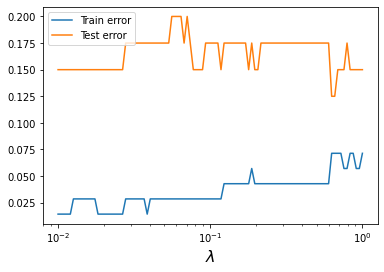

In [8]:
import matplotlib.pyplot as plt

plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()

In [9]:
opt_lambd = lambda_vals[np.argmin(test_error)]
print(f'Optimal lambda is {opt_lambd}')

Optimal lambda is 0.6280291441834256


In [15]:
lambd.value = opt_lambd
#lambd.value = 0.01
prob.solve()

0.5838603562288585

In [16]:
def predict(X, w, w0):
    return np.sign(np.dot(X, w) - w0).reshape(1, -1)

In [17]:
def accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

In [18]:
y_pred = predict(X_test, w.value, w0.value)

In [19]:
print(f"Accuracy : {accuracy(y_test, y_pred)}")

Accuracy : 0.875
